# Resources

[huggingface-workshop](https://github.com/mmsamiei/huggingface-workshop)


[aparat_HuggingFace](https://www.aparat.com/v/4Jivq/%D9%88%D8%B1%DA%A9%D8%B4%D8%A7%D9%BE_%DB%8C%D8%A7%D8%AF%DA%AF%DB%8C%D8%B1%DB%8C_%D8%A7%D9%86%D8%AA%D9%82%D8%A7%D9%84%DB%8C_%D8%AF%D8%B1_NLP_%D8%A8%D8%A7_%DA%A9%D8%AA%D8%A7%D8%A8%D8%AE%D8%A7%D9%86%D9%87_%DB%8C_HuggingFace_%D8%AA%D9%88%D8%B3%D8%B7)

# load datasets and Pre Processing 

In [10]:
import warnings
warnings.filterwarnings('ignore')
from torchvision.transforms import ToTensor, Resize
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from transformers import AutoModel
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
# import torchtext
import glob
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torchvision.transforms import ToTensor, Resize, Compose
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report




import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import PIL 
import os
import pandas as pd
import re

In [18]:
! pip install transformers
! pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 850.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 44.8 MB/s eta 0:00:00


In [3]:
! git clone https://github.com/amnghd/Persian_poems_corpus.git

Cloning into 'Persian_poems_corpus'...
remote: Enumerating objects: 159, done.
remote: Total 159 (delta 0), reused 0 (delta 0), pack-reused 159
Receiving objects: 100% (159/159), 45.21 MiB | 9.26 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (148/148), done.


## Pre-Processing

In [11]:
all_poems_path = glob.glob("Persian_poems_corpus/normalized/*.txt")
pathes = random.sample(all_poems_path, k=10)
poet_name = [name.split("/")[-1].split("_")[0] for name in pathes]
print("10 random poet names :", poet_name)

10 random poet names : ['moulavi', 'anvari', 'zahir', 'sanaee', 'parvin', 'babaafzal', 'naserkhosro', 'asad', 'obeyd', 'jami']


In [13]:
import csv
char_remov = ['\n', '\t']
with open('poems.csv', 'w', encoding='utf-8') as data:
    w = csv.writer(data)
    for path in pathes:
        with open(path, 'r') as poem:
            for sen in poem.readlines():
                for char in char_remov:
                    sen = sen.replace(char, '')
                if sen != '':
                    w.writerow([sen, pathes.index(path)])

In [14]:
df = pd.read_csv('poems.csv', encoding='utf-8').dropna()
df.columns = ['Mesra' , 'Poet']
df

,Mesra,Poet
0,بشنو این نی چون شکایت می کند,0
1,از جداییها حکایت می کند,0
2,کز نیستان تا مرا ببریده اند,0
3,در نفیرم مرد و زن نالیده اند,0
4,سینه خواهم شرحه شرحه از فراق,0
...,...,...
262152,چه خوش گفت دانا که در خانه کس,9
262153,چو باشد ز گوینده یک حرف بس,9
262154,همان به که در کوی دل ره کنیم,9
262155,زبان را بدین حرف کوته کنیم,9


In [15]:
train, test = train_test_split(df, train_size=0.8)

In [20]:
from transformers import AutoConfig, AutoTokenizer, BertForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")
tokenize_train = tokenizer(train['Mesra'].tolist(), truncation=True, padding=True, max_length=256)
tokenize_test = tokenizer(test['Mesra'].tolist(), truncation=True, padding=True, max_length=256)

# Part 1: train FC of model

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [28]:
# Poem_Poet_Dataset
class PoemDataset(Dataset):
    def __init__(self, encode, label):
        self.encode = encode
        self.label = label

    def __getitem__(self, idx):
        input_ids = torch.tensor(self.encode['input_ids'][idx])
        token_type_ids = torch.tensor(self.encode['token_type_ids'][idx])
        attention_mask = torch.tensor(self.encode['attention_mask'][idx])
        label = torch.tensor(self.label[idx])
        return input_ids,token_type_ids,attention_mask,label

    def __len__(self):
        return len(self.label)
# Poem_Poet_Network
class PoemNetwork(nn.Module):
  def __init__(self):
    super(PoemNetwork, self).__init__()
    self.bert = AutoModel.from_pretrained('HooshvareLab/bert-fa-base-uncased')
    self.FC1 = nn.Linear(768, 32)
    self.FC2 = nn.Linear(32, 10)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input_ids, attention_mask):
    bert_model = self.bert(input_ids, attention_mask=attention_mask)[1]
    x = F.relu(self.FC1(bert_model))
    x = self.FC2(x)
    softMax = self.softmax(x)

    return softMax

In [29]:
training_dataset = PoemDataset(tokenize_train, train['Poet'].tolist())
test_dataset = PoemDataset(tokenize_test, test['Poet'].tolist())

In [55]:
batchSize = 128

train_dataloader = DataLoader(training_dataset, batch_size=batchSize, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batchSize, shuffle=True)

In [56]:
model = PoemNetwork()
model.to(device)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PoemNetwork(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

In [57]:
for param in model.bert.parameters():
    param.requires_grad = False

In [58]:
learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,T_max=5,eta_min=1e-5,last_epoch=-1,verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


In [59]:
from tqdm import tqdm
def train_loop(epoch, dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    avgLoss = 0
    avgCorrect = 0
    model.train()
    with tqdm(dataloader, unit="batch") as tepoch:
        for  (X, token, mask, label) in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}")
            
            # Compute prediction and loss
            size_batch = X.shape[0]

            X = X.to(device)
            mask = mask.to(device)
            label = label.to(device)
            pred = model(X, attention_mask=mask)

            loss = loss_fn(pred, label)
            avgLoss += loss.item()
            correct = (pred.argmax(1) == label).type(torch.float).sum().item()
            avgCorrect += correct
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            correct = correct / size_batch
            
            tepoch.set_postfix(batch_loss=loss.item(), batch_accuracy=100. * correct)
            
    avgLoss /= size
    avgCorrect /= size
    print(f" -Training Accuracy (Avg) = {(100*avgCorrect):>0.1f}%, Avg loss = {avgLoss:>8f} \n")
    return avgCorrect, avgLoss

def test_loop(dataloader, model, loss_fn, error):
    size = len(dataloader.dataset)
    avgLoss = 0
    avgCorrect = 0
    model.eval()
    with torch.no_grad():
        for  (X, token, mask, label) in dataloader:
            # Compute prediction and loss
            X = X.to(device)
            mask = mask.to(device)
            label = label.to(device)
            pred = model(input_ids=X, attention_mask=mask)

            avgLoss += loss_fn(pred, label).item()
            avgCorrect += (pred.argmax(1) == label).type(torch.float).sum().item()

    avgLoss /= size
    avgCorrect /= size
    print(f" -{error} : Accuracy = {(100*avgCorrect):>0.1f}%, Avg loss = {avgLoss:>8f} \n")
    return avgCorrect, avgLoss

In [60]:

epochs = 5
for iter in range(epochs):
    print(f" Epoch {iter+1} -------------------------------")
    trainAcc, trainLoss = train_loop(iter, train_dataloader, model, loss_fn, optimizer)

    valAcc, valLoss = test_loop(test_dataloader, model, loss_fn, 'Test')

    scheduler.step()
print("Done!")

 Epoch 1 -------------------------------


Epoch 1: 100%|██████████| 1639/1639 [03:47<00:00,  7.19batch/s, batch_accuracy=29.5, batch_loss=2.13]


 -Training Accuracy (Avg) = 29.6%, Avg loss = 0.016836 

 -Test : Accuracy = 32.1%, Avg loss = 0.016655 

Adjusting learning rate of group 0 to 9.0546e-04.
 Epoch 2 -------------------------------


Epoch 2: 100%|██████████| 1639/1639 [03:46<00:00,  7.22batch/s, batch_accuracy=26.2, batch_loss=2.17]


 -Training Accuracy (Avg) = 31.7%, Avg loss = 0.016680 

 -Test : Accuracy = 33.7%, Avg loss = 0.016569 

Adjusting learning rate of group 0 to 6.5796e-04.
 Epoch 3 -------------------------------


Epoch 3: 100%|██████████| 1639/1639 [03:47<00:00,  7.20batch/s, batch_accuracy=31.1, batch_loss=2.15]


 -Training Accuracy (Avg) = 32.4%, Avg loss = 0.016635 

 -Test : Accuracy = 34.0%, Avg loss = 0.016535 

Adjusting learning rate of group 0 to 3.5204e-04.
 Epoch 4 -------------------------------


Epoch 4: 100%|██████████| 1639/1639 [03:48<00:00,  7.18batch/s, batch_accuracy=41, batch_loss=2.07]


 -Training Accuracy (Avg) = 32.7%, Avg loss = 0.016611 

 -Test : Accuracy = 34.1%, Avg loss = 0.016526 

Adjusting learning rate of group 0 to 1.0454e-04.
 Epoch 5 -------------------------------


Epoch 5: 100%|██████████| 1639/1639 [03:47<00:00,  7.22batch/s, batch_accuracy=27.9, batch_loss=2.19]


 -Training Accuracy (Avg) = 33.0%, Avg loss = 0.016594 

 -Test : Accuracy = 34.2%, Avg loss = 0.016513 

Adjusting learning rate of group 0 to 1.0000e-05.
Done!


In [61]:
y_pred = []
y_true = []

with torch.no_grad():
    for  (X, token, mask, label) in test_dataloader:
        X = X.to(device)
        mask = mask.to(device)
        label = label.to(device)
        pred = model(input_ids=X, attention_mask=mask)
        output = pred.argmax(1).cpu().numpy()
        y_pred.extend(output)
        label = label.cpu().numpy()
        y_true.extend(label)

In [62]:
print(classification_report(y_true=y_true,
                            y_pred=y_pred,
                            target_names=poet_name))

              precision    recall  f1-score   support

     moulavi       0.34      0.47      0.40     10599
      anvari       0.00      0.00      0.00      5385
       zahir       0.00      0.00      0.00      1450
      sanaee       0.29      0.35      0.32     10299
      parvin       0.00      0.00      0.00      2238
   babaafzal       0.00      0.00      0.00       187
 naserkhosro       0.00      0.00      0.00      4492
        asad       0.00      0.00      0.00      3558
       obeyd       0.00      0.00      0.00      1114
        jami       0.37      0.71      0.49     13110

    accuracy                           0.34     52432
   macro avg       0.10      0.15      0.12     52432
weighted avg       0.22      0.34      0.26     52432



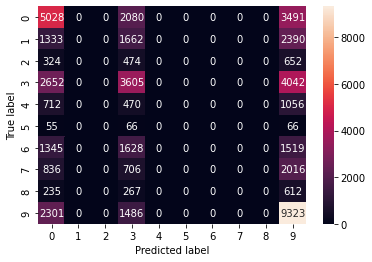

In [66]:
cf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

sb.heatmap(cf_matrix,
           annot=True,
           fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Part 2 : Fine-tune Model

### Adam optimizer :

In [67]:
model_fineTuned_adam = PoemNetwork()
model_fineTuned_adam.to(device)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PoemNetwork(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

In [68]:
for param in model_fineTuned_adam.bert.parameters():
    param.requires_grad = True

In [69]:
learning_rate = 2e-5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_fineTuned_adam.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,T_max=5,eta_min=1e-6,last_epoch=-1,verbose=True)
epochs = 5
for iter in range(epochs):
    print(f" Epoch {iter+1} -------------------------------")
    trainAcc, trainLoss = train_loop(iter, train_dataloader, model_fineTuned_adam, loss_fn, optimizer)

    valAcc, valLoss = test_loop(test_dataloader, model_fineTuned_adam, loss_fn, 'Test')

    scheduler.step()

print("Done!")

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 1 -------------------------------


Epoch 1: 100%|██████████| 1639/1639 [11:30<00:00,  2.37batch/s, batch_accuracy=36.1, batch_loss=2.08]


 -Training Accuracy (Avg) = 37.0%, Avg loss = 0.016355 

 -Test : Accuracy = 42.2%, Avg loss = 0.015930 

Adjusting learning rate of group 0 to 1.8186e-05.
 Epoch 2 -------------------------------


Epoch 2: 100%|██████████| 1639/1639 [11:30<00:00,  2.37batch/s, batch_accuracy=54.1, batch_loss=1.93]


 -Training Accuracy (Avg) = 44.2%, Avg loss = 0.015759 

 -Test : Accuracy = 46.5%, Avg loss = 0.015604 

Adjusting learning rate of group 0 to 1.3436e-05.
 Epoch 3 -------------------------------


Epoch 3: 100%|██████████| 1639/1639 [11:31<00:00,  2.37batch/s, batch_accuracy=50.8, batch_loss=1.96]


 -Training Accuracy (Avg) = 49.7%, Avg loss = 0.015337 

 -Test : Accuracy = 50.1%, Avg loss = 0.015313 

Adjusting learning rate of group 0 to 7.5643e-06.
 Epoch 4 -------------------------------


Epoch 4: 100%|██████████| 1639/1639 [11:31<00:00,  2.37batch/s, batch_accuracy=55.7, batch_loss=1.89]


 -Training Accuracy (Avg) = 53.6%, Avg loss = 0.015036 

 -Test : Accuracy = 51.7%, Avg loss = 0.015181 

Adjusting learning rate of group 0 to 2.8143e-06.
 Epoch 5 -------------------------------


Epoch 5: 100%|██████████| 1639/1639 [11:30<00:00,  2.37batch/s, batch_accuracy=54.1, batch_loss=1.91]


 -Training Accuracy (Avg) = 55.8%, Avg loss = 0.014863 

 -Test : Accuracy = 52.5%, Avg loss = 0.015123 

Adjusting learning rate of group 0 to 1.0000e-06.
Done!


In [70]:
y_pred = []
y_true = []

with torch.no_grad():
    for  (X, token, mask, label) in test_dataloader:
        X = X.to(device)
        mask = mask.to(device)
        label = label.to(device)
        pred = model_fineTuned_adam(input_ids=X, attention_mask=mask)
        output = pred.argmax(1).cpu().numpy()
        y_pred.extend(output)
        label = label.cpu().numpy()
        y_true.extend(label)

In [71]:
print(classification_report(y_true=y_true,
                            y_pred=y_pred,
                            target_names=poet_name))

              precision    recall  f1-score   support

     moulavi       0.56      0.74      0.64     10599
      anvari       0.00      0.00      0.00      5385
       zahir       0.00      0.00      0.00      1450
      sanaee       0.41      0.61      0.49     10299
      parvin       0.00      0.00      0.00      2238
   babaafzal       0.00      0.00      0.00       187
 naserkhosro       0.00      0.00      0.00      4492
        asad       0.50      0.68      0.58      3558
       obeyd       0.00      0.00      0.00      1114
        jami       0.60      0.83      0.70     13110

    accuracy                           0.52     52432
   macro avg       0.21      0.29      0.24     52432
weighted avg       0.38      0.52      0.44     52432



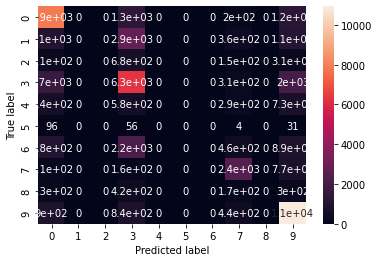

In [72]:
cf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

sb.heatmap(cf_matrix,
           annot=True,)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

### SGD Optimizer:

In [73]:
model_fineTuned_sgd = PoemNetwork()
model_fineTuned_sgd.to(device)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PoemNetwork(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

In [74]:
for param in model_fineTuned_sgd.bert.parameters():
    param.requires_grad = True

In [75]:
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter(log_dir='MLP_Board')

learning_rate = 2e-5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_fineTuned_sgd.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,T_max=5,eta_min=1e-6,last_epoch=-1,verbose=True)

epochs = 5
for iter in range(epochs):
    print(f" Epoch {iter+1} -------------------------------")
    trainAcc, trainLoss = train_loop(iter, train_dataloader, model_fineTuned_sgd, loss_fn, optimizer)
    # writer.add_scalar('Accuracy/train', trainAcc, e)
    # writer.add_scalar('Loss/train', trainLoss, e)

    valAcc, valLoss = test_loop(test_dataloader, model_fineTuned_sgd, loss_fn, 'Test')
    # writer.add_scalar('Accuracy/validation', valAcc, e)
    # writer.add_scalar('Loss/validation', valLoss, e)
    scheduler.step()
    
print("Done!")

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 1 -------------------------------


Epoch 1: 100%|██████████| 1639/1639 [10:08<00:00,  2.69batch/s, batch_accuracy=8.2, batch_loss=2.3]


 -Training Accuracy (Avg) = 7.4%, Avg loss = 0.017996 

 -Test : Accuracy = 7.3%, Avg loss = 0.018002 

Adjusting learning rate of group 0 to 1.8186e-05.
 Epoch 2 -------------------------------


Epoch 2: 100%|██████████| 1639/1639 [10:07<00:00,  2.70batch/s, batch_accuracy=8.2, batch_loss=2.3]


 -Training Accuracy (Avg) = 7.4%, Avg loss = 0.017989 

 -Test : Accuracy = 7.1%, Avg loss = 0.017995 

Adjusting learning rate of group 0 to 1.3436e-05.
 Epoch 3 -------------------------------


Epoch 3: 100%|██████████| 1639/1639 [10:08<00:00,  2.69batch/s, batch_accuracy=9.84, batch_loss=2.3]


 -Training Accuracy (Avg) = 7.3%, Avg loss = 0.017983 

 -Test : Accuracy = 7.1%, Avg loss = 0.017990 

Adjusting learning rate of group 0 to 7.5643e-06.
 Epoch 4 -------------------------------


Epoch 4: 100%|██████████| 1639/1639 [10:08<00:00,  2.69batch/s, batch_accuracy=6.56, batch_loss=2.3]


 -Training Accuracy (Avg) = 7.2%, Avg loss = 0.017979 

 -Test : Accuracy = 7.1%, Avg loss = 0.017987 

Adjusting learning rate of group 0 to 2.8143e-06.
 Epoch 5 -------------------------------


Epoch 5: 100%|██████████| 1639/1639 [10:08<00:00,  2.69batch/s, batch_accuracy=13.1, batch_loss=2.3]


 -Training Accuracy (Avg) = 7.2%, Avg loss = 0.017977 

 -Test : Accuracy = 7.1%, Avg loss = 0.017985 

Adjusting learning rate of group 0 to 1.0000e-06.
Done!


In [76]:
y_pred = []
y_true = []

with torch.no_grad():
    for  (X, token, mask, label) in test_dataloader:
        X = X.to(device)
        mask = mask.to(device)
        label = label.to(device)
        pred = model_fineTuned_sgd(input_ids=X, attention_mask=mask)
        output = pred.argmax(1).cpu().numpy()
        y_pred.extend(output)
        label = label.cpu().numpy()
        y_true.extend(label)

In [77]:
print(classification_report(y_true=y_true,
                            y_pred=y_pred,
                            target_names=poet_name))

              precision    recall  f1-score   support

     moulavi       0.00      0.00      0.00     10599
      anvari       0.09      0.05      0.07      5385
       zahir       0.00      0.00      0.00      1450
      sanaee       0.00      0.00      0.00     10299
      parvin       0.00      0.00      0.00      2238
   babaafzal       0.00      0.00      0.00       187
 naserkhosro       0.00      0.00      0.00      4492
        asad       0.07      0.96      0.13      3558
       obeyd       0.00      0.00      0.00      1114
        jami       0.43      0.00      0.00     13110

    accuracy                           0.07     52432
   macro avg       0.06      0.10      0.02     52432
weighted avg       0.12      0.07      0.02     52432



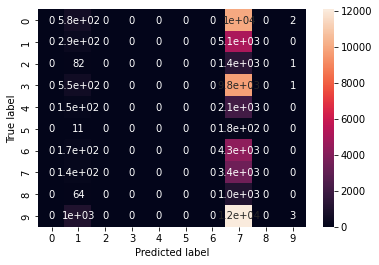

In [78]:
cf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

sb.heatmap(cf_matrix,
           annot=True,)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Part 3 : Perplexity

In [80]:
dfSample = df.sample(1000)
tokenize_sample = tokenizer(dfSample['Mesra'].tolist(), truncation=True, padding=True, max_length=256)
sample_dataset = PoemDataset(tokenize_sample, dfSample['Poet'].tolist())

sample_dataloader = DataLoader(sample_dataset, batch_size=64, shuffle=True)

In [81]:
loss_fn = nn.CrossEntropyLoss()
def metrics(dataloader, model, loss_fn):
    y_pred = []
    y_true = []
    loss = 0
    with torch.no_grad():
        for  (X, token, mask, label) in sample_dataloader:
            X = X.to(device)
            mask = mask.to(device)
            label = label.to(device)
            pred = model(input_ids=X, attention_mask=mask)

            loss += loss_fn(pred, label).item() * (X.size(0)/X.size(1))

            output = pred.argmax(1).cpu().numpy()
            y_pred.extend(output)
            label = label.cpu().numpy()
            y_true.extend(label)
            
    return y_true, y_pred, loss

In [82]:
true_fix, pred_fix, loss = metrics(sample_dataloader, model, loss_fn)
print("Perplexity : ", np.exp(loss/len(sample_dataloader)))

Perplexity :  7014.990749284262


In [83]:
true_fix, pred_fix, loss = metrics(sample_dataloader, model_fineTuned_adam, loss_fn)
print("Perplexity : ", np.exp(loss/len(sample_dataloader)))

Perplexity :  2757.487625833382


In [86]:
true_fix, pred_fix,loss = metrics(sample_dataloader, model,loss_fn)

> Perplexity is usually used only to determine how well a model has learned the training set. as you can see, model that fine tuned worked better beacuase the perplexity is much lower than another model(without fine tuned)

# transformer 

In [87]:
id2label = { poet_name.index(i):i for i in poet_name}
label2id = { i:poet_name.index(i) for i in poet_name}

In [90]:
from transformers import AutoConfig, AutoTokenizer, BertForSequenceClassification
from datasets import load_metric

config = AutoConfig.from_pretrained("HooshvareLab/bert-fa-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")
bert_model = BertForSequenceClassification.from_pretrained("HooshvareLab/bert-fa-base-uncased" , num_labels = 10, id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

In [91]:
from datasets import load_dataset
train.to_csv('train.csv', index=False, encoding='utf-8')
test.to_csv('test.csv', index=False, encoding='utf-8')

data_files = {"train" : "train.csv",
              "test" : "test.csv"}
dataset = load_dataset("csv", data_files=data_files )
dataset

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-f4280a40de4d8ffe/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Mesra', 'Poet'],
        num_rows: 209725
    })
    test: Dataset({
        features: ['Mesra', 'Poet'],
        num_rows: 52432
    })
})

In [93]:
tokenize_dataset = dataset.map(lambda data: tokenizer(data['Mesra'], truncation=True, padding="max_length"), batched=True)

  0%|          | 0/210 [00:00<?, ?ba/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/53 [00:00<?, ?ba/s]

In [94]:
tokenize_dataset

DatasetDict({
    train: Dataset({
        features: ['Mesra', 'Poet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 209725
    })
    test: Dataset({
        features: ['Mesra', 'Poet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 52432
    })
})